In [2]:
!pip install xgboost catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


АНАЛИЗ BREAST CANCER WISCONSIN DATASET
Загрузка данных...
Целевые классы: ['malignant' 'benign']
Размер датасета: (569, 30)

РАСПРЕДЕЛЕНИЕ КЛАССОВ:
  malignant: 212 (37.3%)
  benign: 357 (62.7%)

РАЗДЕЛЕНИЕ ДАННЫХ:
Обучающая выборка: 398 samples
Тестовая выборка: 171 samples

СТАНДАРТИЗАЦИЯ ПРИЗНАКОВ...
Стандартизация завершена!
Обучение моделей...
  - Decision Tree
  - Random Forest
  - AdaBoost
  - XGBoost
  - CatBoost
Обучение завершено!


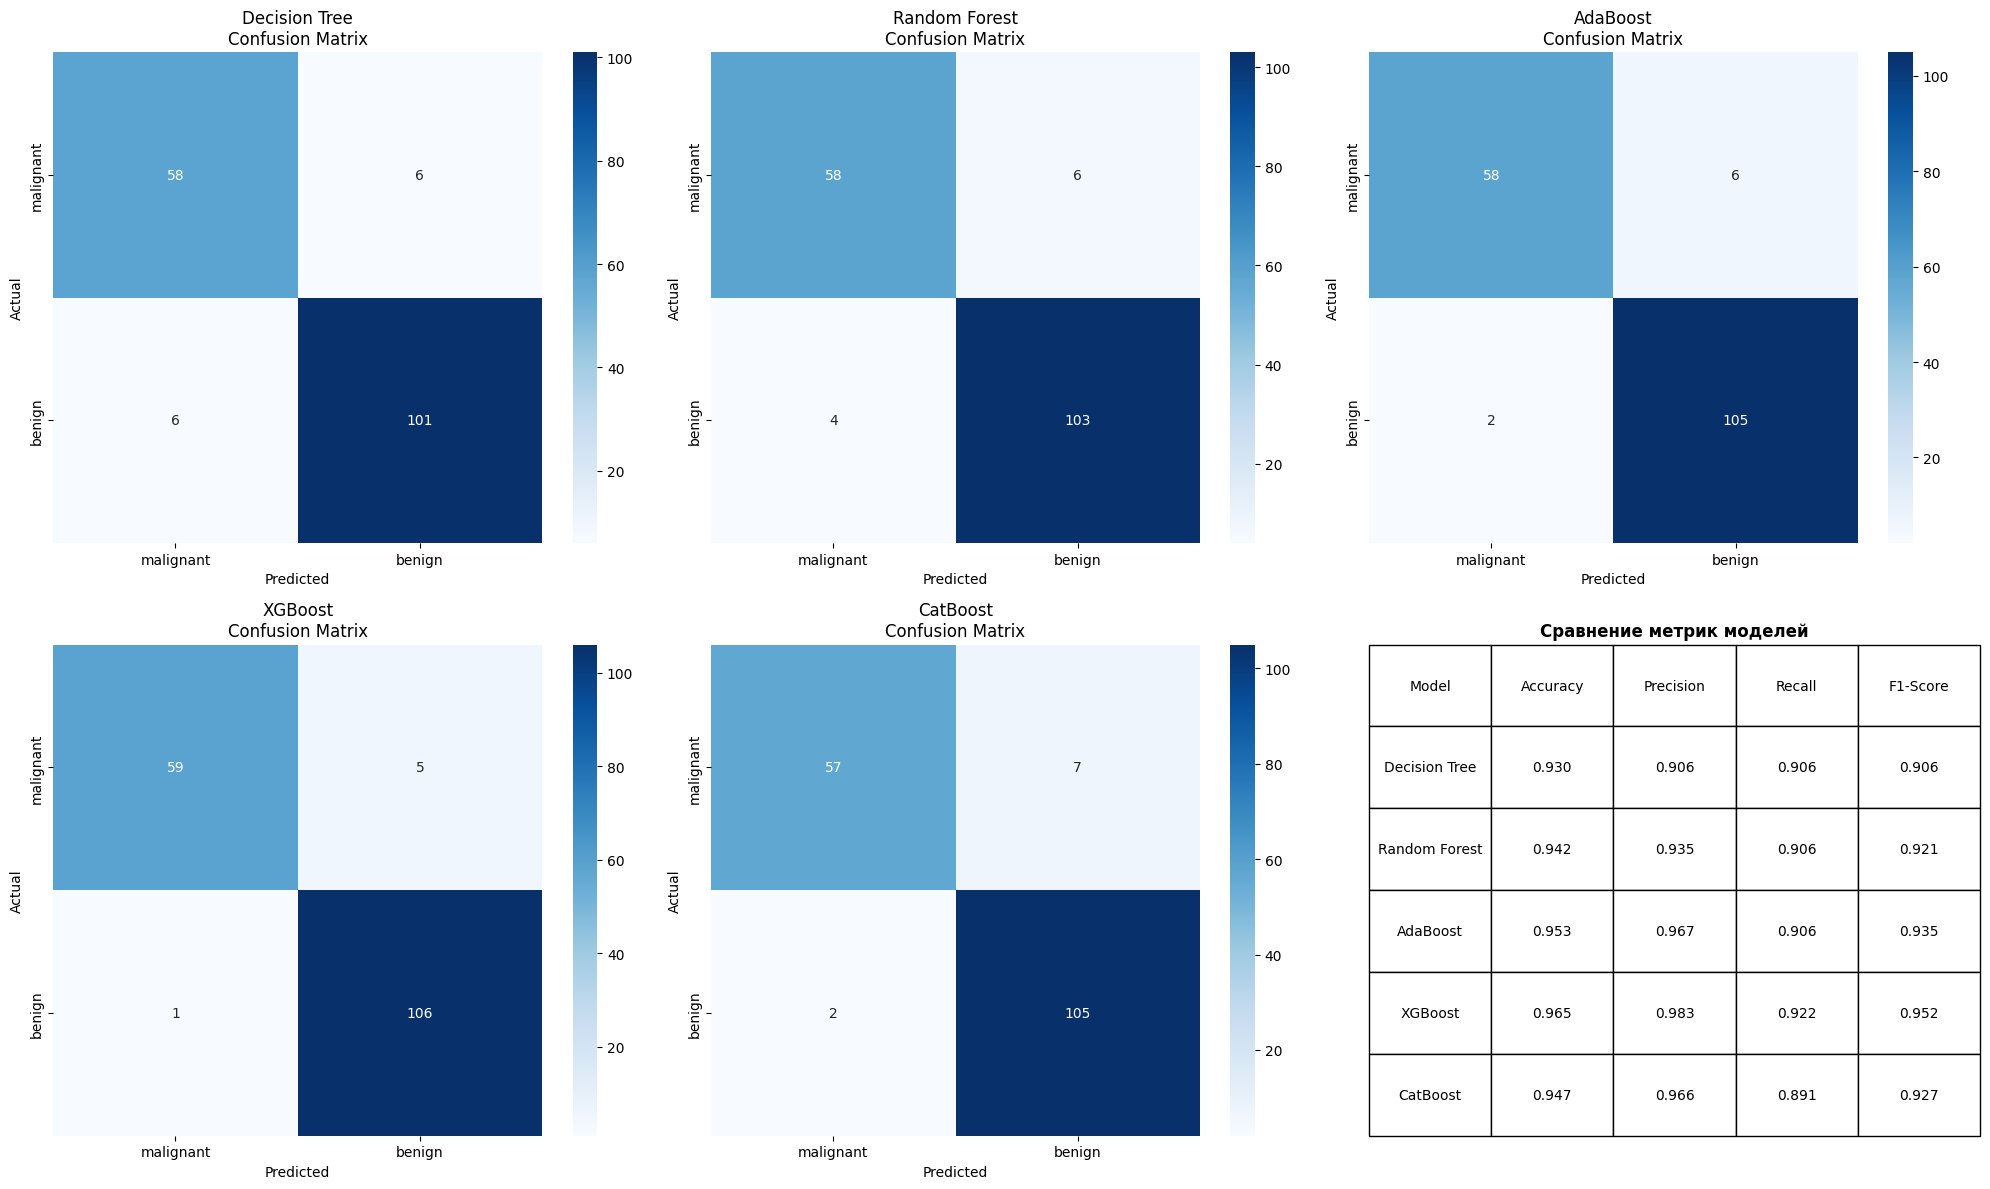


Decision Tree:
----------------------------------------
Матрица ошибок:
                Predicted
               malignant    benign      
Actual malignant 58           6           
       benign   6            101         

Метрики для класса 'malignant' (злокачественная):
  Precision: 0.906
  Recall:    0.906
  F1-Score:  0.906
  Accuracy:  0.930
  Ложноотрицательные: 6 (5.6% от реально злокачественных)

Random Forest:
----------------------------------------
Матрица ошибок:
                Predicted
               malignant    benign      
Actual malignant 58           6           
       benign   4            103         

Метрики для класса 'malignant' (злокачественная):
  Precision: 0.935
  Recall:    0.906
  F1-Score:  0.921
  Accuracy:  0.942
  Ложноотрицательные: 4 (3.7% от реально злокачественных)

AdaBoost:
----------------------------------------
Матрица ошибок:
                Predicted
               malignant    benign      
Actual malignant 58           6           
  

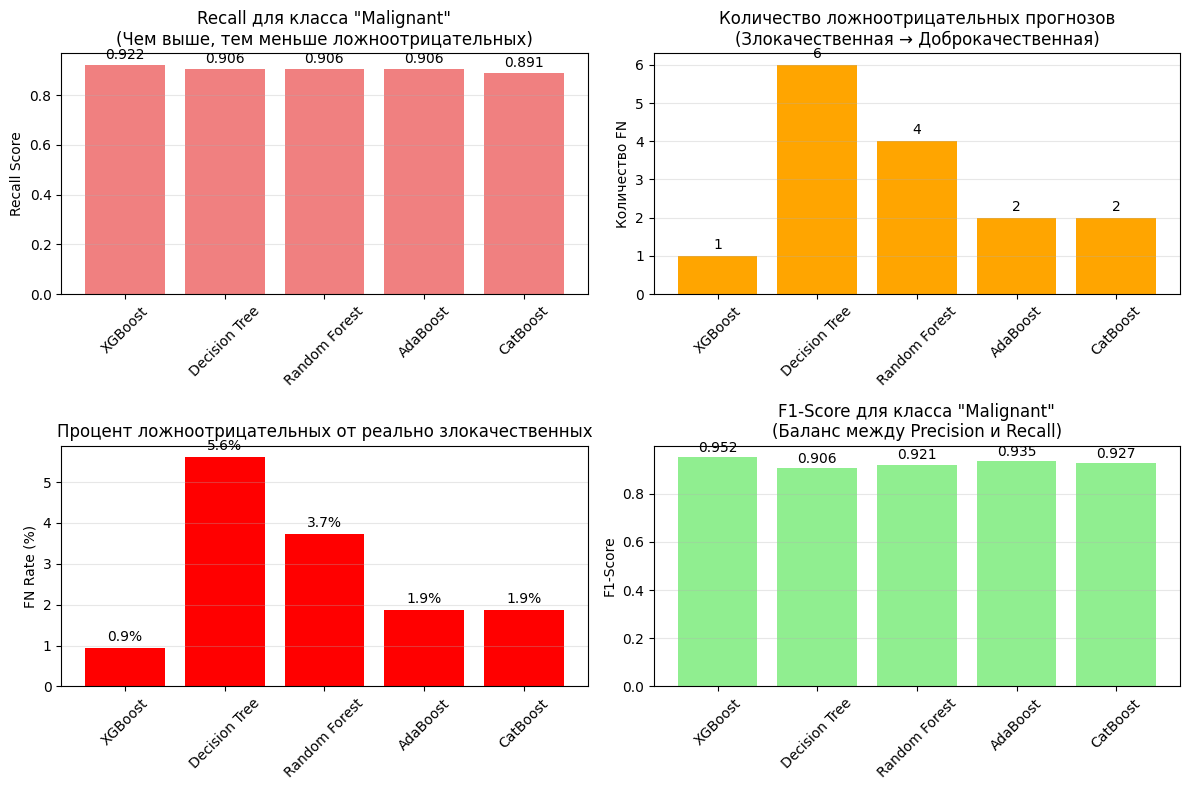

 НАИБОЛЕЕ НАДЕЖНАЯ МОДЕЛЬ ДЛЯ МИНИМИЗАЦИИ ЛОЖНООТРИЦАТЕЛЬНЫХ ПРОГНОЗОВ:
   Модель: XGBoost
   Recall: 0.922
   Ложноотрицательные: 1 случаев (0.9%)
   F1-Score: 0.952
   • Модель правильно идентифицирует 92.2% реально злокачественных опухолей


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("АНАЛИЗ BREAST CANCER WISCONSIN DATASET")
print("=" * 70)

print("Загрузка данных...")
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

target_names = data.target_names
print(f"Целевые классы: {target_names}")
print(f"Размер датасета: {X.shape}")

print("\nРАСПРЕДЕЛЕНИЕ КЛАССОВ:")
class_counts = y.value_counts().sort_index()
for i, count in class_counts.items():
    class_name = target_names[i]
    percentage = count / len(y) * 100
    print(f"  {class_name}: {count} ({percentage:.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nРАЗДЕЛЕНИЕ ДАННЫХ:")
print(f"Обучающая выборка: {X_train.shape[0]} samples")
print(f"Тестовая выборка: {X_test.shape[0]} samples")

print("\nСТАНДАРТИЗАЦИЯ ПРИЗНАКОВ...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Стандартизация завершена!")

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(n_estimators=100, random_state=42, verbose=False)
}

results = {}
predictions = {}

print("Обучение моделей...")
for name, model in models.items():
    print(f"  - {name}")
    if name in ['XGBoost', 'CatBoost']:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    predictions[name] = y_pred

    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)
    accuracy = model.score(X_test_scaled if name not in ['XGBoost', 'CatBoost'] else X_test, y_test)

    results[name] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    }

print("Обучение завершено!")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names, ax=axes[idx])
    axes[idx].set_title(f'{name}\nConfusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df[['accuracy', 'precision', 'recall', 'f1']]

axes[5].axis('off')

table_data = []
for model in metrics_df.index:
    row = [model]
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        row.append(f"{results[model][metric]:.3f}")
    table_data.append(row)

table = axes[5].table(cellText=table_data,
                     colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[5].set_title('Сравнение метрик моделей', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

for name in models.keys():
    print(f"\n{name}:")
    print("-" * 40)
    y_pred = predictions[name]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"Матрица ошибок:")
    print(f"                Predicted")
    print(f"               {target_names[0]:<12} {target_names[1]:<12}")
    print(f"Actual {target_names[0]:<8} {tn:<12} {fp:<12}")
    print(f"       {target_names[1]:<8} {fn:<12} {tp:<12}")

    print(f"\nМетрики для класса '{target_names[0]}' (злокачественная):")
    print(f"  Precision: {results[name]['precision']:.3f}")
    print(f"  Recall:    {results[name]['recall']:.3f}")
    print(f"  F1-Score:  {results[name]['f1']:.3f}")
    print(f"  Accuracy:  {results[name]['accuracy']:.3f}")

    fn_rate = fn / (fn + tp)
    print(f"  Ложноотрицательные: {fn} ({fn_rate:.1%} от реально злокачественных)")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Recall_Malignant': [results[name]['recall'] for name in results.keys()],
    'FN_Count': [confusion_matrix(y_test, predictions[name]).ravel()[2] for name in results.keys()],
    'FN_Rate': [confusion_matrix(y_test, predictions[name]).ravel()[2] /
                (confusion_matrix(y_test, predictions[name]).ravel()[2] +
                 confusion_matrix(y_test, predictions[name]).ravel()[3]) for name in results.keys()],
    'F1_Score': [results[name]['f1'] for name in results.keys()]
})

comparison_df = comparison_df.sort_values('Recall_Malignant', ascending=False)

print("Рейтинг моделей по способности обнаруживать злокачественные опухоли:")
print("-" * 80)
for idx, row in comparison_df.iterrows():
    print(f"{row['Model']:.<15} Recall: {row['Recall_Malignant']:.3f} | "
          f"Ложноотрицательные: {int(row['FN_Count'])} ({row['FN_Rate']:.1%}) | "
          f"F1: {row['F1_Score']:.3f}")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
bars = plt.bar(comparison_df['Model'], comparison_df['Recall_Malignant'], color='lightcoral')
plt.title('Recall для класса "Malignant"\n(Чем выше, тем меньше ложноотрицательных)')
plt.ylabel('Recall Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
for bar, recall in zip(bars, comparison_df['Recall_Malignant']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{recall:.3f}', ha='center', va='bottom')

plt.subplot(2, 2, 2)
bars = plt.bar(comparison_df['Model'], comparison_df['FN_Count'], color='orange')
plt.title('Количество ложноотрицательных прогнозов\n(Злокачественная → Доброкачественная)')
plt.ylabel('Количество FN')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
for bar, count in zip(bars, comparison_df['FN_Count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{int(count)}', ha='center', va='bottom')

plt.subplot(2, 2, 3)
bars = plt.bar(comparison_df['Model'], comparison_df['FN_Rate'] * 100, color='red')
plt.title('Процент ложноотрицательных от реально злокачественных')
plt.ylabel('FN Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
for bar, rate in zip(bars, comparison_df['FN_Rate'] * 100):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{rate:.1f}%', ha='center', va='bottom')

plt.subplot(2, 2, 4)
bars = plt.bar(comparison_df['Model'], comparison_df['F1_Score'], color='lightgreen')
plt.title('F1-Score для класса "Malignant"\n(Баланс между Precision и Recall)')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
for bar, f1 in zip(bars, comparison_df['F1_Score']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{f1:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

best_model = comparison_df.iloc[0]
print(f" НАИБОЛЕЕ НАДЕЖНАЯ МОДЕЛЬ ДЛЯ МИНИМИЗАЦИИ ЛОЖНООТРИЦАТЕЛЬНЫХ ПРОГНОЗОВ:")
print(f"   Модель: {best_model['Model']}")
print(f"   Recall: {best_model['Recall_Malignant']:.3f}")
print(f"   Ложноотрицательные: {int(best_model['FN_Count'])} случаев ({best_model['FN_Rate']:.1%})")
print(f"   F1-Score: {best_model['F1_Score']:.3f}")

print(f"   • Модель правильно идентифицирует {best_model['Recall_Malignant']:.1%} реально злокачественных опухолей")